# LSTM model for forecasting temperature

## Import necessary libs

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from pandas import date_range
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Activation, Dropout,RepeatVector,TimeDistributed,Flatten,Conv1D,MaxPooling1D

from tensorflow.keras.optimizers import Adam,SGD,Nadam

import unittest
import timeit

## Training LSTM model with one station 

### Read file

#### First we read the temperature data from all station from Victoria

Check the folder containg the "vic_temperature_data.csv"

In [ ]:
temperature_data = pd.read_csv("vic_temperature_data.csv")

The temperature data includes:
 - Product code (Not using)
 - Station Number: Each station has unique station number
 - Year/Month/Day
 - Maximum/Minimum temperature: will be used for training model
 - Day of accumulation of maximum temperature (Not using)
 - Quality x (Not using)
 - Station name
 - LGA
 - Latitude/Longtitude
 

In [3]:
temperature_data

,Product code_x,Station Number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_x,Product code_y,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality_y,stationname,localgovernmentarea,latitude,longtitude,Date Time
0,IDCJAC0010,76031.0,2000.0,1,1.0,24.9,1.0,Y,IDCJAC0011,10.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-01
1,IDCJAC0010,76031.0,2000.0,1,2.0,30.9,1.0,Y,IDCJAC0011,12.5,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-02
2,IDCJAC0010,76031.0,2000.0,1,3.0,34.8,1.0,Y,IDCJAC0011,17.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-03
3,IDCJAC0010,76031.0,2000.0,1,4.0,24.3,1.0,Y,IDCJAC0011,13.0,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-04
4,IDCJAC0010,76031.0,2000.0,1,5.0,25.6,1.0,Y,IDCJAC0011,9.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586471,IDCJAC0010,90186.0,2020.0,8,2.0,15.0,1.0,N,IDCJAC0011,5.8,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-02
586472,IDCJAC0010,90186.0,2020.0,8,3.0,12.9,1.0,N,IDCJAC0011,5.9,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-03
586473,IDCJAC0010,90186.0,2020.0,8,4.0,10.6,1.0,N,IDCJAC0011,2.5,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-04
586474,IDCJAC0010,90186.0,2020.0,8,5.0,11.0,1.0,N,IDCJAC0011,5.6,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-05


### Find out the number of LGAs

We use in-buillt function unique() to find all the LGA from the csv file

In [4]:
temperature_data['localgovernmentarea'].unique()

array(['Mildura Shire', 'Swan Hill', 'Horsham',
       'Naracoorte and Lucindale', 'Northern Grampians', 'Campaspe',
       'Central Goldfields', 'Greater Shepparton', 'Greater Bendigo',
       'Moira', 'Corowa Shire', 'Murrindindi', 'Alpine', 'Wangaratta',
       'Greater Hume Shire', 'Benalla', 'Mansfield', 'Bega Valley',
       'East Gippsland', 'Bombala', 'Wellington', 'Latrobe',
       'Moonee Valley', 'Banyule', nan, 'Knox', 'Bass Coast', 'Brimbank',
       'Mornington Peninsula', 'Casey', 'Yarra Ranges', 'Wyndham',
       'Greater Geelong', 'Mount Alexander', 'Whittlesea',
       'Ballarat North', 'Ararat', 'Colac-Otway', 'Glenelg',
       'Southern Grampians', 'Moyne', 'Warrnambool', 'Surf Coast',
       'Grant'], dtype=object)

### Get the data from one LGA

Extract the data from Mildura Shire. One LGA may contain many stations

In [5]:
selected_lga="Mildura Shire"
selected_lga_data = temperature_data[temperature_data['localgovernmentarea']=="Mildura Shire"]

### Get the data from one weather station

Since our csv file contains many temperature data from many stations and LGA so we need to extract data from one LGA

In [6]:
selected_lga_data['stationname'].unique()

array(['MILDURA AIRPORT ', 'OUYEN (POST OFFICE) ', 'WALPEUP RESEARCH ',
       'HOPETOUN AIRPORT '], dtype=object)

In [7]:
selected_station_name="MILDURA AIRPORT "
selected_station_data=selected_lga_data[selected_lga_data['stationname']=="MILDURA AIRPORT "]

In [8]:
product_codex = selected_station_data["Product code_x"][0]
product_codey = selected_station_data["Product code_y"][0]

station_latitude = selected_station_data["latitude"][0]
station_longtitude = selected_station_data["longtitude"][0]
selected_station_number = selected_station_data["Station Number"][0]
selected_station_data

,Product code_x,Station Number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_x,Product code_y,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality_y,stationname,localgovernmentarea,latitude,longtitude,Date Time
0,IDCJAC0010,76031.0,2000.0,1,1.0,24.9,1.0,Y,IDCJAC0011,10.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-01
1,IDCJAC0010,76031.0,2000.0,1,2.0,30.9,1.0,Y,IDCJAC0011,12.5,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-02
2,IDCJAC0010,76031.0,2000.0,1,3.0,34.8,1.0,Y,IDCJAC0011,17.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-03
3,IDCJAC0010,76031.0,2000.0,1,4.0,24.3,1.0,Y,IDCJAC0011,13.0,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-04
4,IDCJAC0010,76031.0,2000.0,1,5.0,25.6,1.0,Y,IDCJAC0011,9.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7519,IDCJAC0010,76031.0,2020.0,8,2.0,21.1,1.0,N,IDCJAC0011,5.8,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-02
7520,IDCJAC0010,76031.0,2020.0,8,3.0,19.5,1.0,N,IDCJAC0011,5.5,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-03
7521,IDCJAC0010,76031.0,2020.0,8,4.0,14.0,1.0,N,IDCJAC0011,4.0,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-04
7522,IDCJAC0010,76031.0,2020.0,8,5.0,14.1,1.0,N,IDCJAC0011,-1.1,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-05


Because we will train two models (one for minimum temperature, other one for maximum temperature) so we need to extract min and max temperature and assign them to two separate data frames

### Extract the minimum temperature

In [9]:
selected_station_mintemp=selected_station_data[["Date Time","Minimum temperature (Degree C)"]]

In [10]:
selected_station_mintemp['Date Time']=pd.to_datetime(selected_station_mintemp['Date Time'])
selected_station_mintemp = selected_station_mintemp.set_index(selected_station_mintemp.columns[0])

<ipython-input-10-f74a45df9b2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_station_mintemp['Date Time']=pd.to_datetime(selected_station_mintemp['Date Time'])


Plot the min temperature data

<AxesSubplot:xlabel='Date Time'>

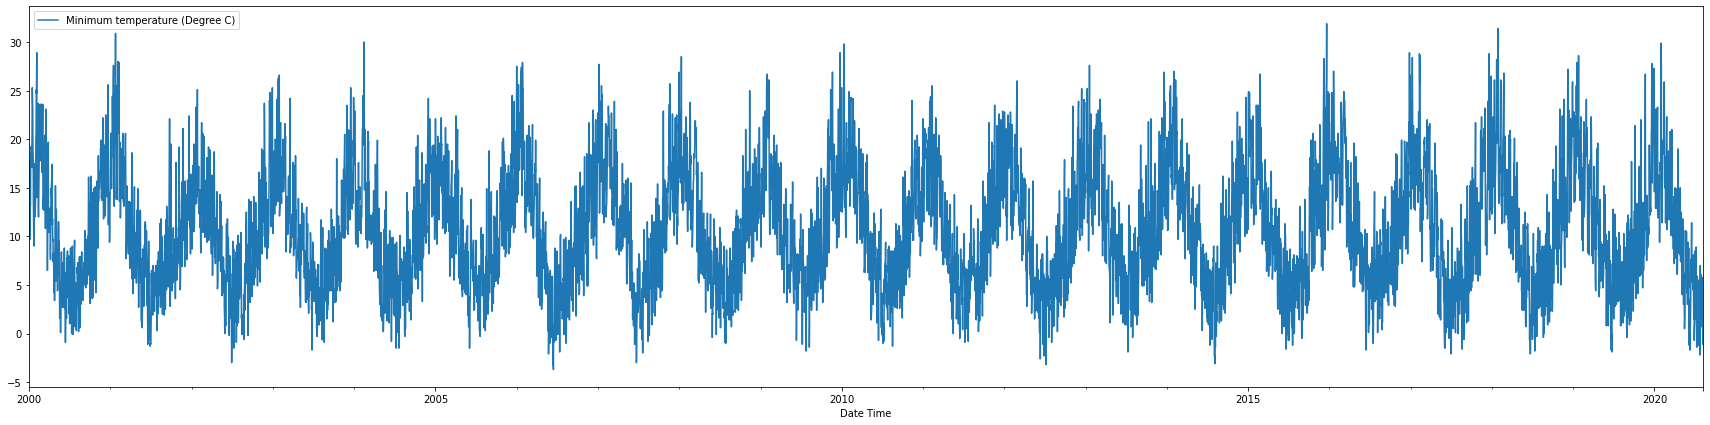

In [11]:
selected_station_mintemp.plot(figsize=(30,7))

### Extract the maximum data

<ipython-input-12-53741390e578>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_station_maxtemp['Date Time']=pd.to_datetime(selected_station_maxtemp['Date Time'])


<AxesSubplot:xlabel='Date Time'>

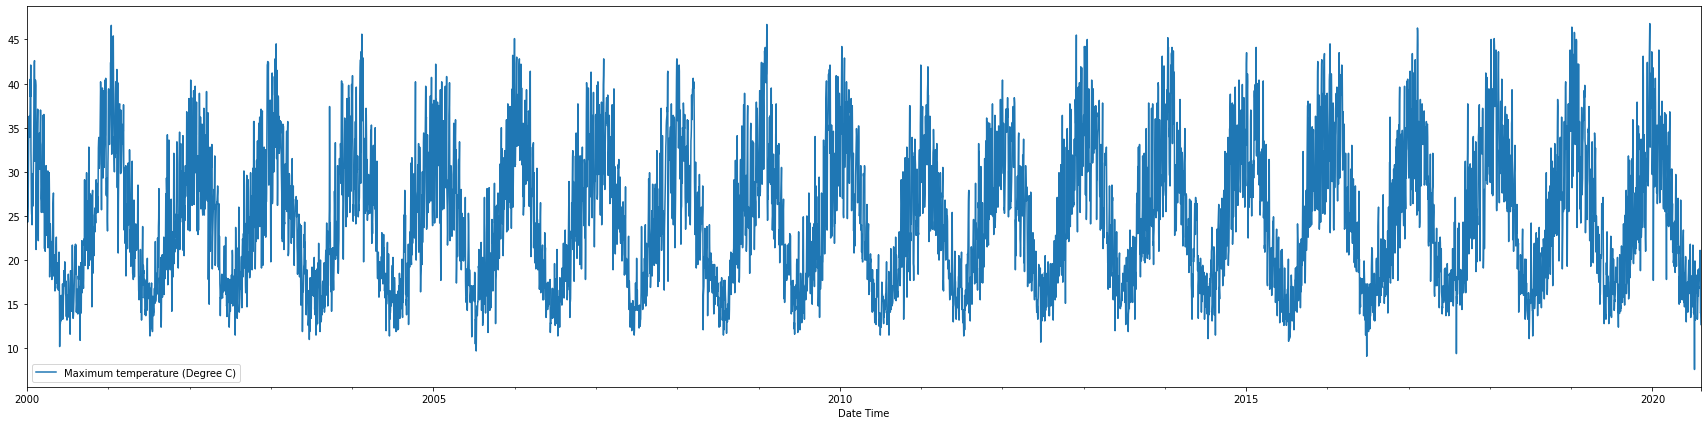

In [12]:
selected_station_maxtemp=selected_station_data[["Date Time","Maximum temperature (Degree C)"]]
selected_station_maxtemp['Date Time']=pd.to_datetime(selected_station_maxtemp['Date Time'])
selected_station_maxtemp = selected_station_maxtemp.set_index(selected_station_maxtemp.columns[0])
selected_station_maxtemp.plot(figsize=(30,7))

### Train test split

We need to split the original data into two subsets. One is used to train the model, test set will be used to evaluate the model and compute the accuracy <br/>
Normally the ratio will be 0.8 or 0.9 that means 80% or 90% of the original data will be used as training set

In [30]:
def train_test_split(data_set,name,ratio):
    """
    Splitting the data set into two subsets based on the given ratio
    
    Parameters:
    -----------
        data_set(Data Frame): Orginal temperature data from one station
        name (string): Station name
        ratio(float): number of training data / number of data_set
    
    Returns:
    --------
        train_set(Data Frame): Training data to train the model
        test_set(Data Frame): Test data for evaluation
        split_row(int): row number splits the training data and test data in the original data set
    """
    
    print(name+' total samples: ',len(data_set))
    #Identify the row we will split up the data set
    split_row = int(len(data_set)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',len(data_set)-split_row)
    #Split the data based on the split row calculated above
    train_set = data_set.iloc[:split_row]
    test_set = data_set.iloc[split_row:]
    return train_set, test_set, split_row 
    

Test train_test_split function

In [14]:
train_data,test_data,split_r= train_test_split(selected_station_mintemp,"mildura",0.8)

mildura total samples:  7524
Training samples:  6019
Testing samples:  1505


### Data Transformation

We need to scale the the data so it will reduce the computional cost of the training step and also avoid gradient vanishing problem

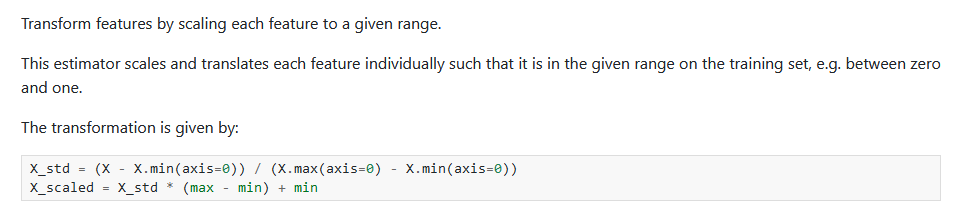
We will use Minmax Scaler from sklearn library

In [31]:
def data_transformation(train_data,testing_data):
    """
    Scale the original data using MinMaxScaler with the range from -1 to 1
    
    Parameters:
    -----------
        data (Data Frame): data set need to be scaled
        testing_data (Data Frame): test set need to be scaled
    
    Returns:
    --------
        scaled_train_data(Data Frame): Scaled Data
        scaled_test_data(Data Frame): Scaled test data
        my_scaler(MinMaxScaler): MinMaxScaler object (used to inverse scaled data)
    
    """
    if type(train_data).__module__ !="pandas.core.frame" :
        raise TypeError("train_data is not DataFrame type")
    if type(testing_data).__module__ !="pandas.core.frame":
        raise TypeError("testing_data is not DataFrame type")
    #Initialize the scaler
    my_scaler=MinMaxScaler(feature_range=(-1,1))
    #Normalize the train and test data
    train_data_scaled = my_scaler.fit_transform(train_data)
    test_data_scaled = my_scaler.fit_transform(testing_data)
    #Convert from numpy matrix to Dataframe type
    scaled_train_data_df = pd.DataFrame(train_data_scaled, index = train_data.index, columns=[train_data.columns[0]])
    test_data_scaled_df = pd.DataFrame(test_data_scaled, index = testing_data.index, columns=[testing_data.columns[0]])
    
    return scaled_train_data_df,test_data_scaled_df,my_scaler

### Add time step to the data
We will use the last n number of time step data to predict temperature of next day. <br/>
In order to predict the temperature at t+1 (next day), we need temperature at t , t-1 ,...., t-n. Basically we turn the whole data set into many smaller sequences, each sequence has a corresponding labeled value. <br/><br/>
After adding time step (e.g. time steps =7) to the data <br/>
-----------------------x-----------------------------|------y-----|<br/>
[x(t-7),x(t-6),x(t-5),x(t-3),x(t-2),x(t-1),x(t)]  |    [x(t+1)]|

In [32]:
def add_time_step(x,y,time_steps):
    """
    Chop the original data into smaller sequences for modelling
    
    Parameters:
    -----------
        x(Data Frame): training input data
        y(Numpy array): labeled data
        time_steps(int): Length of each sequence
        
    Return:
    -------
        x_tr(Numpy array): List of sequences (Input for model)
        y_tr(Numpy array): Labeled data corresponding to each sequence in x_tr
    """
    if time_steps < 0:
        raise ValueError("Time step value cannot be negative")
        
    
    x_p,y_p=[],[]
    for i in range (len(x) - time_steps):
        #Extract the data from x to get a sequence having number of elements = time steps
        x_p.append(x.iloc[i:(i+time_steps)].values)
        #Extract the output y corresponding to each sequence
        y_p.append(y[i + time_steps])
    x_tr,y_tr=np.array(x_p),np.array(y_p)
    x_tr = np.reshape(x_tr, (x_tr.shape[0], x_tr.shape[1], 1))
    y_tr = np.reshape(y_tr, (y_tr.shape[0], 1))
    return x_tr,y_tr

## Define LSTM model

LSTM model includes 1 Bidirectional LSTM layer with number of hidden cells is defined by user and one dense layer with one neuron for output. There is a drop out layers (ratio 0.2) to prevent the gradient vanishing problem and Nadam method for gradient optimization.

In [255]:
def lstm(units, x_train,y_train,EPOCHS,size_batch):
    """
    Build and Train LSTM model
    
    Parameters:
    -----------
        units(int): Number of units for each model layer
        x_train(list): traing data fed into model (predictor data)
        y_train(list): label data/ actual predicted value (used to compare with the value produced from the model)
        EPOCHS(int): number of times we train the model with whole training data set
        size_batch(int):number of training examples used in one iteration
    Returns:
    --------
        model(Tensorflow object): Trained model
        hist: Contains accuracy and everything related to the training model
    
    """
    if type(x_train).__module__ != np.__name__ or type(y_train).__module__ != np.__name__:
        raise TypeError("Input data must to be numpy array")
    
    
    model = Sequential()
    #Add a LSTM layer
    model.add(Bidirectional(LSTM(units,return_sequences=False,input_shape=(x_train.shape[1],1))))
    model.add(Dropout(0.2))
    #Output layer
    model.add(Dense(1))
    #We use Nadam optimisation algorithm and mean_squared error to calculate the loss
    model.compile(optimizer=Nadam(lr=0.001),loss='mean_squared_error',metrics=['mae'])

    hist = model.fit(x_train,y_train,batch_size=size_batch,epochs=EPOCHS,shuffle=False,verbose=1)
    return model,hist

## Temperature Predicting Model

There are two separate forecasting models for minimum temperature and maximum temperature

In [262]:
def min_temp_lstm(units,batch_size,n_epoch,station_name,data_from_station,lag,split_ratio):
    """
    Process data and train minimum temperature forecasting model
    
    Parameters:
    -----------
        units(int): Number of cells for each LSTM layers
        batch_size(int): number of training examples used in one iteration
        n_epoch(int): number of times we train the model with whole training data set
        station_name:(str): 
        data_from_station(Data Frame): Original data containing the minimum temperature with corresponding date from one station from one station
        lag(int): Number of timesteps to 
        split_ratio(float): Used to split data into training data set and testing data set
    Returns:
    --------
        model(Tensorflow object): A full trained model that predict temperature one step ahead based one the temperature
                                 of n timsteps
        hist(Tensorflow object): Information about the training process (e.g. Accuracy, Loss,...)
        test_data_scaled(Data Frame): The (scaled) test set that was split from the orginal data
        my_scaler(MinMaxScaler): The scaler that was used to normalize the original data
        
    """
    
    #Error Handling for input
    if units <= 0 :
        raise ValueError("Number of units cannot be negative")
    if batch_size <= 0:
        raise ValueError("Batch size cannot be negative")
    if  n_epoch <=0:
        raise ValueError("Number of epoch cannot be negative")
    if lag <=0:
        raise ValueError("Lag value cannot be negative")
    if split_ratio<=0 or split_ratio >1:
        raise ValueError("Split_ratio need to be from 0 to 1")
    if !isinstance(station_name,str):
        raise TypeError("station_name must be string")
        
    
    #split original data
    train_data,test_data,split_row=train_test_split(data_from_station,station_name,split_ratio)
    #normalizing data
    train_data_scaled,test_data_scaled,my_scaler = data_transformation(train_data,test_data)
    #generate a list of sequences data
    x_train,y_train=add_time_step(train_data_scaled,train_data_scaled["Minimum temperature (Degree C)"],lag)
    model,hist = lstm(units,x_train,y_train,n_epoch,batch_size)
    return model,hist,test_data_scaled,my_scaler

def max_temp_lstm(units,batch_size,n_epoch,station_name,data_from_station,lag,split_ratio):
    """
    Process data and train maximum temperature forecasting model
    
    Parameters:
    -----------
        units(int): Number of cells for each LSTM layers. The higher number of units, the more complexity model is.
        batch_size(int): number of training examples used in one iteration
        n_epoch(int): number of times we train the model with whole training data set
        station_name:(str): 
        data_from_station(Data Frame): Original data containing the maximum temperature with corresponding date from one station
        lag(int): Number of timesteps to 
        split_ratio(float): Used to split data into training data set and testing data set
    Returns:
    --------
        model(Tensorflow object): A full trained model that predict temperature one step ahead based one the temperature
                                 of n timsteps
        hist(Tensorflow object): Information about the training process (e.g. Accuracy, Loss,...)
        test_data_scaled(Data Frame): The (scaled) test set that was split from the orginal data
        my_scaler(MinMaxScaler): The scaler that was used to normalize the original data
        
    """
    #Error Handling for input
    if units <= 0 :
        raise ValueError("Number of units cannot be negative")
    if batch_size <= 0:
        raise ValueError("Batch size cannot be negative")
    if  n_epoch <=0:
        raise ValueError("Number of epoch cannot be negative")
    if lag <=0:
        raise ValueError("Lag value cannot be negative")
    if split_ratio<=0 or split_ratio >1:
        raise ValueError("Split_ratio need to be from 0 to 1")
    if !isinstance(station_name,str):
        raise TypeError("station_name must be string")
    
    train_data,test_data,split_row=train_test_split(data_from_station,station_name,split_ratio)
    train_data_scaled,test_data_scaled,my_scaler = data_transformation(train_data,test_data)
    x_train,y_train=add_time_step(train_data_scaled,train_data_scaled["Maximum temperature (Degree C)"],lag)
    model,hist = lstm(units,x_train,y_train,n_epoch,batch_size)
    return model,hist,test_data_scaled,my_scaler

### Train forecasting minimum temperature model

We train the the minimum model with the data from Mildura Airport station:
 - Number of Units = 50
 - Number of Epochs = 40
 - Batch size = 40
 - Time step = 365
 - Split ratio = 0.9

In [256]:
min_model,min_hist,min_test,min_scaler = min_temp_lstm(50,50,40,"Mildura Shire",selected_station_mintemp,365,0.9)

Mildura Shire total samples:  7524
Training samples:  6771
Testing samples:  753
Epoch 1/40
129/129 [==============================] - 26s 200ms/step - loss: 0.0473 - mae: 0.1750
Epoch 2/40
129/129 [==============================] - 26s 202ms/step - loss: 0.0426 - mae: 0.1666
Epoch 3/40
129/129 [==============================] - 25s 193ms/step - loss: 0.0403 - mae: 0.1619
Epoch 4/40
129/129 [==============================] - 25s 193ms/step - loss: 0.0382 - mae: 0.1570
Epoch 5/40
129/129 [==============================] - 26s 199ms/step - loss: 0.0364 - mae: 0.1530
Epoch 6/40
129/129 [==============================] - 27s 208ms/step - loss: 0.0351 - mae: 0.1498
Epoch 7/40
129/129 [==============================] - 27s 208ms/step - loss: 0.0345 - mae: 0.1487
Epoch 8/40
129/129 [==============================] - 27s 207ms/step - loss: 0.0340 - mae: 0.1469
Epoch 9/40
129/129 [==============================] - 28s 220ms/step - loss: 0.0341 - mae: 0.1474
Epoch 10/40
129/129 [================

### Train forecasting maximum temperature model

In [264]:
max_model,max_hist,max_test,max_scaler = max_temp_lstm(50,50,40,"Mildura Shire",selected_station_maxtemp,365,0.9)

Mildura Shire total samples:  7524
Training samples:  6771
Testing samples:  753
Epoch 1/40
129/129 [==============================] - 26s 202ms/step - loss: 0.0624 - mae: 0.1988
Epoch 2/40
129/129 [==============================] - 25s 193ms/step - loss: 0.0507 - mae: 0.1792
Epoch 3/40
129/129 [==============================] - 26s 203ms/step - loss: 0.0477 - mae: 0.1734
Epoch 4/40
129/129 [==============================] - 25s 193ms/step - loss: 0.0440 - mae: 0.1654
Epoch 5/40
129/129 [==============================] - 25s 195ms/step - loss: 0.0407 - mae: 0.1578
Epoch 6/40
129/129 [==============================] - 25s 195ms/step - loss: 0.0390 - mae: 0.1532
Epoch 7/40
129/129 [==============================] - 25s 194ms/step - loss: 0.0384 - mae: 0.1511
Epoch 8/40
129/129 [==============================] - 25s 192ms/step - loss: 0.0379 - mae: 0.1493
Epoch 9/40
129/129 [==============================] - 25s 191ms/step - loss: 0.0375 - mae: 0.1488
Epoch 10/40
129/129 [================

## Evaluate the model

### Evaluating minimum temperature model

Text(0, 0.5, 'MSE')

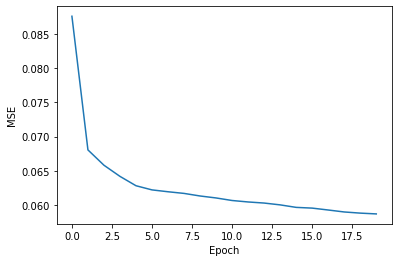

In [66]:
# Plot the mae graph for min temperature model
plt.plot(min_hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')

## Forecast temperature for next n days

In [281]:
forecasted_min_temp=forecast(min_model,min_scaler,min_test[-365:].values,300)

In [270]:
forecasted_max_temp=forecast(max_model,max_scaler,max_test[-365:].values,300)

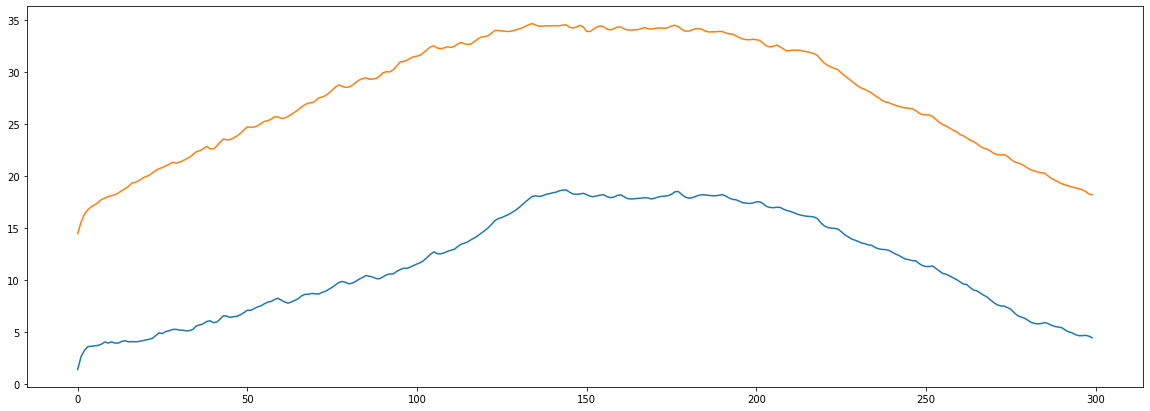

In [279]:
plt.figure(figsize=(20,7))
plt.plot(np.array(range(300)),forecasted_min_temp)
plt.plot(np.array(range(300)),forecasted_max_temp)

As can be seen from the graph above, the predicted temperature pattern has really good trend when the temperature values are higher in summer season. However, these values have low varianace so we cannot show the extreme weather/temperature. To do that, we can improve the model using Attention LSTM model or stateful LSTM model.

In [268]:
def forecast(model,scaler,data,days):
    """
    Predict Min/Max temperature of next n days
    
    Parameters:
    -----------
        model(Tensorflow object): A trained model
        data(Numpy array): Temperature data of previous m (m=predefined timestep above) days used to 
                          predict temperature of next days
        days (int): Number of days in the future we want to predict temperature
    
    Returns:
    --------
        predicted_data(Numpy array): The forecasted scaled temperature of next n days. These scaled values need to be inverted
    """
    if type(model).__module__  == 'tensorflow.python.keras.engine.sequential':
        raise TypeError("Model is not in the correct type")
    if type(scaler).__module__ =="sklearn.preprocessing._data":
        raise TypeError("Scaler Type Error ")
    if days <=0:
        raise ValueError("Number of days cannot be negative")
    
    predicted_data=[]
    historical_data = data
    historical_data=historical_data.reshape((1,data.shape[0],1))
    for i in range(days):
        #Use the trained model to predict next day temperature
        new_predict = model.predict(historical_data)
        historical_data=np.reshape(historical_data,(historical_data.shape[1]))
        historical_data= np.append(historical_data,new_predict)
        #Remove the first value and append the new predicted value
        historical_data = historical_data[1::]
        historical_data=np.reshape(historical_data,(1,historical_data.shape[0],1))
        predicted_data.append(new_predict)
        predicted_data.append(scaler.inverse_transform(new_predict.reshape(-1,1)))
    return np.array(predicted_data).reshape((days))

## Predicting temperature for all station

In [16]:
#Find all the weather station 
weather_station_no=temperature_data['Station Number'].unique()

In [1]:
weather_station_no = np.array([76031.0])

count =0
print("Station Number for training ",weather_station_no)
# Declare some variables
lag=365
num_of_forecasting_data_days= 300
split_ratio = 0.9
n_units=50
batch_size=50
n_epochs=40

#Create forecasted data frame (similar structure like the original data)
forecasted_df = pd.DataFrame(columns=['Product code_x','Station Number','Year','Month','Day','Maximum temperature (Degree C)','Days of accumulation of maximum temperature','Quality_x','Product code_y','Minimum temperature (Degree C)','Days of accumulation of minimum temperature','Quality_y','stationname','localgovernmentarea','latitude','longtitude','Date Time'])
model=[]
#Create accuracy table contain accuracy value of each model
accuracy_table = pd.DataFrame(columns=['Station Number','r2_min','r2_max'])

#Main loop
for station_number in weather_station_no:
    #create a temporary data frame for each station
    temp_forecasted_df = pd.DataFrame(columns=['Product code_x','Station Number','Year','Month','Day','Maximum temperature (Degree C)','Days of accumulation of maximum temperature','Quality_x','Product code_y','Minimum temperature (Degree C)','Days of accumulation of minimum temperature','Quality_y','stationname','localgovernmentarea','latitude','longtitude','Date Time'])
    
    print("Number of Stations remains: ",len(weather_station_no)-count)
    count +=1
    
    ## Get the data with current station number
    weather_station_data = temperature_data[temperature_data["Station Number"]==station_number]
    print("Station Number ",station_number)
    print("Station Name ",weather_station_data["stationname"].iloc[0])
    print("Number of data: ",len(weather_station_data["Product code_x"]))
    print("-----------------------------------Training------------------------------------")
 
    ## Get all information go with that station
    temp_forecasted_df["Product code_x"]=np.repeat(weather_station_data["Product code_x"].iloc[0],num_of_forecasting_data_days)
    temp_forecasted_df["Station Number"]=np.repeat(station_number,num_of_forecasting_data_days)
    temp_forecasted_df["Product code_y"] = np.repeat(weather_station_data["Product code_y"].iloc[0],num_of_forecasting_data_days)
    temp_forecasted_df["latitude"] = np.repeat(weather_station_data["latitude"].iloc[0],num_of_forecasting_data_days)
    temp_forecasted_df["longtitude"] = np.repeat(weather_station_data["longtitude"].iloc[0],num_of_forecasting_data_days)
    temp_forecasted_df["stationname"] = np.repeat(weather_station_data["stationname"].iloc[0],num_of_forecasting_data_days)
    temp_forecasted_df["localgovernmentarea"]=np.repeat(weather_station_data["localgovernmentarea"].iloc[0],num_of_forecasting_data_days)

    ## Extract min data
    selected_station_mintemp=weather_station_data[["Date Time","Minimum temperature (Degree C)"]]
    selected_station_mintemp['Date Time']=pd.to_datetime(selected_station_mintemp['Date Time'])
    selected_station_mintemp = selected_station_mintemp.set_index(selected_station_mintemp.columns[0])
    
    ##Extract max data
    selected_station_maxtemp=weather_station_data[["Date Time","Maximum temperature (Degree C)"]]
    selected_station_maxtemp['Date Time']=pd.to_datetime(selected_station_maxtemp['Date Time'])
    selected_station_maxtemp = selected_station_maxtemp.set_index(selected_station_maxtemp.columns[0])
    
    ## Training Step
    print("------------Training model predicting min temperature---------")
    
    min_model,min_hist,min_test,min_scaler = min_temp_lstm(n_units,batch_size,n_epochs,weather_station_data["stationname"].iloc[0],selected_station_mintemp,lag,split_ratio)
    
    ##Save model
    model_path = "vic_model/" +str(station_number) + "_min_model"
    min_model.save(model_path)
    
    ## Evaluate min model on the test set
    #Processing the test set
    min_test,min_test_scaler=data_transformation(min_test)
    x_test,y_test=add_time_step(min_test,min_test["Minimum temperature (Degree C)"],lag)
    x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
    predicted_temp=min_model.predict(x_test,verbose=1)
    predicted_temp=predicted_temp.reshape((predicted_temp.shape[0],1))
    predicted_temp=min_test_scaler.inverse_transform(predicted_temp)
    y_test=min_test_scaler.inverse_transform(y_test)
    #Calculate r2 score
    r2_min_score=r2_score(y_test,predicted_temp)
    print("R2_score: ",r2_min_score)
    
    ## Training max model
    print("------------Training model predicting max temperature---------")
    max_model,max_hist,max_test,max_scaler = max_temp_lstm(n_units,batch_size,n_epochs,weather_station_data["stationname"].iloc[0],selected_station_maxtemp,lag,split_ratio)
    
    ##Save model
    model_path = "vic_model/" +str(station_number) + "_max_model"
    max_model.save(model_path)
    
    ## Evaluate max model on the test set  
    #Processing the test set
    x_test,y_test=add_time_step(max_test,max_test["Maximum temperature (Degree C)"],lag)
    x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
    predicted_temp=max_model.predict(x_test,verbose=1)
    predicted_temp=predicted_temp.reshape((predicted_temp.shape[0],1))
    predicted_temp=max_scaler.inverse_transform(predicted_temp)
    y_test=max_scaler.inverse_transform(y_test)
    #Calculate r2 score
    r2_max_score=r2_score(y_test,predicted_temp)
    print("R2_score: ",r2_max_score)
    model.append(min_model)
    model.append(max_model)

    ##Update accuracy table
    temp_acc = pd.DataFrame([[station_number,r2_min_score,r2_max_score]], columns=['Station Number','r2_min','r2_max'])
    accuracy_table=pd.concat([accuracy_table,temp_acc])
    
    
    #Prepare data for forecasting
    forecast_mintemp_data=np.array(min_test[-lag:]).reshape((1,lag,1))
    forecast_maxtemp_data=np.array(max_test[-lag:]).reshape((1,lag,1))
    #Predicting
    forecasted_min_data = forecast(min_model,min_scaler,forecast_mintemp_data,num_of_forecasting_data_days)
    forecasted_max_data = forecast(max_model,max_scaler,forecast_maxtemp_data,num_of_forecasting_data_days)
    
    ## Save the forecasted temperature to the data frame
    temp_forecasted_df["Minimum temperature (Degree C)"]=forecasted_min_data
    temp_forecasted_df["Maximum temperature (Degree C)"]=forecasted_max_data
    
    #### Generate date
    start_date = min_test[-num_of_forecasting_data_days:].index[-1] + timedelta(days=1)
    end_date = min_test[-num_of_forecasting_data_days:].index[-1] + timedelta(days=num_of_forecasting_data_days)
    temp_forecasted_df["Date Time"] = pd.date_range(start_date, end_date)
    
    ### Fill the rest column
    temp_forecasted_df["Year"]=pd.to_datetime(temp_forecasted_df["Date Time"]).dt.strftime('%Y')
    temp_forecasted_df["Month"]=pd.to_datetime(temp_forecasted_df["Date Time"]).dt.strftime('%m')
    temp_forecasted_df["Day"]=pd.to_datetime(temp_forecasted_df["Date Time"]).dt.strftime('%d')

    ##write data to a csv file
    path = "forecasted_data/" + str(int(station_number))+"_forecasted_temp.csv"
    temp_forecasted_df.to_csv(path,index=False)
    
    #merge to the final dataframe
    forecasted_df = pd.concat([forecasted_df, temp_forecasted_df])
#Write all the predicted temperature from all station to one csv file
forecasted_df.to_csv("vic_forecasted_temp.csv",index=False)
accuracy_table.to_csv("vic_model_accuracy.csv",index=False)

NameError: name 'np' is not defined

## Unit Test

In [33]:
class LSTMModelPrepareTesting(unittest.TestCase):
    """
    Testing class to check
        - split data into 2 subsets
        - normalize the data
        - add_time_step function
    """
    def __init__(self,test_name):
        super(LSTMModelPrepareTesting, self).__init__(test_name)
        
    
        
    def test_split_data(self):
        """
        Check the add_time_step function return correct number of training data and test data based on the ratio
        """
        #Generate a random data containing 100 rows
        generated_data_df = pd.DataFrame(columns=["Data"])
        generated_data_df["Data"] = np.array(range(100))
        ratio = 0.8
        n_training_data=100 * ratio
        n_testing_data = 100-n_training_data
        
        # Check number of train and test data
        train_data,test_data,split_row=train_test_split(generated_data_df,"Test",ratio)
        
        self.assertEqual(len(train_data),n_training_data,"Number of training data is not correct")
        self.assertEqual(len(test_data),n_testing_data,"Number of testing data is not correct")
        
    def test_data_transformation(self):
        """
        Check that the value of data need to be in given range
        """
        #Generate a random data containing 100 rows
        generated_data_df = pd.DataFrame(columns=["Data"])
        generated_data_df["Data"] = np.array(range(-50,50))
        
        train_data,test_data,my_scaler=data_transformation(generated_data_df,generated_data_df*2)
        
        #The value after scaling will be from -1 to 1
        out_of_range_train_data=len(train_data[train_data["Data"]>1]) + len(train_data[train_data["Data"]<-1])
        out_of_range_test_data =len(test_data[test_data["Data"]>1]) + len(test_data[test_data["Data"]<-1])
        
        #Check number of out of range train and test data
        self.assertEqual(out_of_range_train_data,0,"There are out of range training data after normalization")
        self.assertEqual(out_of_range_test_data,0,"There are out of range testing data after normalization")
        
    def test_add_time_step_function(self):
        """
        Check the correct of the "add_time_step" fucntion (e.g number of sequences, number of element in a sequence)
        """
        
        #Generate a random data containing 100 rows
        generated_data_df = pd.DataFrame(columns=["Data"])
        generated_data_df["Data"] = np.array(range(-50,50))
        
        time_step=7
        x,y=add_time_step(generated_data_df,generated_data_df.values,time_step)
        
        self.assertEqual(x.shape[0],y.shape[0],"Number of output value is not equal to the number of sequences")
        self.assertEqual(x.shape[1],time_step,"Number of elements in each sequence is not equal to the time step")
        
    def test_processing_data(self):
        """
        Integration Test for 3 functions above. Output of the one function will be fed into next function
        """
        #Generate a random data containing 100 rows
        generated_data_df = pd.DataFrame(columns=["Data"])
        generated_data_df["Data"] = np.array(range(100))
        ratio = 0.8
        n_training_data=100 * ratio
        n_testing_data = 100-n_training_data
        time_step=7
        # Check number of train and test data
        train_data,test_data,split_row=train_test_split(generated_data_df,"Test",ratio)
        scaled_train_data,scaled_test_data,my_scaler=data_transformation(train_data,test_data)
        x,y=add_time_step(scaled_train_data,scaled_train_data.values,time_step)
        
        self.assertEqual(x.shape[0],y.shape[0],"Number of output value is not equal to the number of sequences")
        self.assertEqual(x.shape[1],time_step,"Number of elements in each sequence is not equal to the time step")
        
    
    

In [34]:
test_loader = unittest.TestLoader()
test_names = test_loader.getTestCaseNames(LSTMModelPrepareTesting)
test_suite= unittest.TestSuite()
for test_name in test_names:
    test_suite.addTest(LSTMModelPrepareTesting(test_name))

In [35]:
result = unittest.TextTestRunner().run(test_suite)

....

Test total samples:  100
Training samples:  80
Testing samples:  20
Test total samples:  100
Training samples:  80
Testing samples:  20



----------------------------------------------------------------------
Ran 4 tests in 0.287s

OK


## Performance Test

In [49]:
        
class LSTMModelPreparePerformanceTest():
    """
    Testing class for checking performance of the processing data function
    """
    def generate_dataframe(self,n_size):
        generated_data_df = pd.DataFrame(columns=["Data"])
        generated_data_df["Data"] = np.array(range(n_size))
        return generated_data_df
    def transformation_performance_test(self):
        """
        Performance test for normalizing data
        """
        ##Generate different data set
        data=[]
        size=[100,1000,10000]
        data.append(self.generate_dataframe(10000))
        data.append(self.generate_dataframe(100000))
        data.append(self.generate_dataframe(1000000))
        print("Performance Test for data transformation")
        for i in range(len(data)):
            start = timeit.default_timer()
            train_data,test_data,my_scaler=data_transformation(data[i],data[i]*2)
            stop = timeit.default_timer()
            print("Data Size: " + str(size[i]) + "Time: " + str(stop - start))  
        
    def add_time_step_performance_test(self):
        """
        Performance test for adding time step function
        """
        data=[]
        size=[100,1000,10000]
        data.append(self.generate_dataframe(100))
        data.append(self.generate_dataframe(1000))
        data.append(self.generate_dataframe(10000))
        n_timestep=7
        print("\nPerformance Test for data transformation")
        for i in range(len(data)):
            start = timeit.default_timer()
            train_data,test_data=add_time_step(data[i],data[i].values,n_timestep)
            stop = timeit.default_timer()
            print("Data Size: " + str(size[i]) + " Time: " + str(stop - start)) 
        

In [50]:
performance_test = LSTMModelPreparePerformanceTest()

In [51]:
performance_test.transformation_performance_test()
performance_test.add_time_step_performance_test()

Performance Test for data transformation
Data Size: 100Time: 0.0038654000018141232
Data Size: 1000Time: 0.0055793999999878
Data Size: 10000Time: 0.04204529999697115

Performance Test for data transformation
Data Size: 100 Time: 0.013804399997752625
Data Size: 1000 Time: 0.07764799999858951
Data Size: 10000 Time: 0.7717885999954888
